<a href="https://www.kaggle.com/code/yeoyunsianggeremie/s3e18-pca-eda-catboost-baseline?scriptVersionId=135715137" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a class="anchor" id="import"></a>
# <p style="padding:10px;background-color:#008DD8;margin:0;color:white;font-family:newtimeroman;font-size:150%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500"> S3E18 Notebook: Multi-Label Classification with an Enzyme Substrate Dataset </p> 

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#2e3ca5; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #2e3ca5">Changing Cell Styles</p>

In [1]:
#https://www.kaggle.com/competitions/playground-series-s3e14/discussion/410627

!wget http://bit.ly/3ZLyF82 -O CSS.css -q
    
from IPython.core.display import HTML
with open('./CSS.css', 'r') as file:
    custom_css = file.read()

HTML(custom_css)

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e18/sample_submission.csv
/kaggle/input/playground-series-s3e18/train.csv
/kaggle/input/playground-series-s3e18/test.csv
/kaggle/input/ec-class-prediction-dataset/deferrari150.pdf
/kaggle/input/ec-class-prediction-dataset/64521_submission.csv
/kaggle/input/ec-class-prediction-dataset/65447_submission.csv
/kaggle/input/ec-class-prediction-dataset/nath_e1003642.pdf
/kaggle/input/ec-class-prediction-dataset/nath60.pdf
/kaggle/input/ec-class-prediction-dataset/64845_v5_submission.csv
/kaggle/input/ec-class-prediction-dataset/65810_submission.csv
/kaggle/input/ec-class-prediction-dataset/65446_submission.csv
/kaggle/input/ec-class-prediction-dataset/beattie267.pdf
/kaggle/input/ec-class-prediction-dataset/mussa744.pdf
/kaggle/input/ec-class-prediction-dataset/65557_submission.csv
/kaggle/input/ec-class-prediction-dataset/64706_submission.csv
/kaggle/input/ec-class-prediction-dataset/RF62853_submission.csv
/kaggle/input/ec-class-prediction-dataset/65031_subm

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#2e3ca5; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #2e3ca5">Libraries</p>

In [3]:
!pip install iterative-stratification

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from typing import List

#https://www.kaggle.com/code/kimtaehun/multi-label-classification-with-complete-eda
from colorama import Style, Fore, Back
## Set Plot Parameters       
plt.style.use("Solarize_Light2")
color_pal = ["#4CAF50", "#780060", "#FFBF00", "#6495ED", "#DE3163",
             "#922710", "#C99BE8", "#FF8700", "#E0FF00", "#2E00FF"]

rc = {
    "axes.facecolor": "#FFF9ED",
    "figure.facecolor": "#FFF9ED",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)

blk = Style.BRIGHT + Fore.BLACK
red = Style.BRIGHT + Fore.RED
gld = Style.BRIGHT + Fore.YELLOW
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

from category_encoders import OneHotEncoder, MEstimateEncoder, GLMMEncoder, OrdinalEncoder
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, KFold, RepeatedKFold, train_test_split, cross_val_score
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, LogisticRegression
from sklearn.linear_model import PassiveAggressiveRegressor, ARDRegression
from sklearn.linear_model import TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, roc_curve
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from xgboost import XGBRegressor, XGBClassifier
import lightgbm as lgbm
from lightgbm import LGBMRegressor, LGBMClassifier
from lightgbm import log_evaluation, early_stopping, record_evaluation
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from sklearn import set_config
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.multioutput import MultiOutputClassifier
import gc

import warnings
warnings.filterwarnings('ignore')

set_config(transform_output = 'pandas')

pal = sns.color_palette('viridis')

pd.set_option('display.max_rows', 100)

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#2e3ca5; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #2e3ca5">Configurations</p>

In [5]:
TARGET1 = "EC1"
TARGET2 = "EC2"
RANDOM_STATE = 42
TRAIN_SIZE = 14837

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#2e3ca5; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #2e3ca5">Examine Data</p>

In [6]:
class DataLoader:
    def __init__(self, DATA_DIR, read_original=True, original_dir=""):
        
        self.train = pd.read_csv(DATA_DIR + "train.csv")
        self.test = pd.read_csv(DATA_DIR + "test.csv")
        self.read_original = read_original
        if self.read_original:
            self.original = pd.read_csv(original_dir)
        
    def drop_index(self, cols):
        try:
            self.train = self.train.drop(columns = cols)
        except:
            pass
        
        try:
            self.test = self.test.drop(columns = cols)
        except:
            pass
        
        try:
            if self.read_original:
                self.original = self.original.drop(columns = cols)
        except:
            pass
        
        #removing this reduces 10 fold CV MAE -> try on unseen data first
        if self.read_original:
            self.train = pd.concat([self.train, self.original]).reset_index().drop(columns = ["index"])
        
        return (self.train, self.test)
        

In [7]:
DATA_DIR = '/kaggle/input/playground-series-s3e18/'
orig_dir = '/kaggle/input/ec-mixed-class/'
dl = DataLoader(DATA_DIR, False, orig_dir)
train, test = dl.drop_index(["id"])
train = train.drop(columns = ["EC3", "EC4", "EC5", "EC6"])

In [8]:
desc_df = pd.read_csv(orig_dir + "mixed_desc.csv")
ecfp_df = pd.read_csv(orig_dir + "mixed_ecfp.csv")
fcfp_df = pd.read_csv(orig_dir + "mixed_fcfp.csv")

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#2e3ca5; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #2e3ca5">Concatenate the relevant rows</p>

In [9]:
def buildTrainDF(train, ecfp_df, desc_df):
    
    orig_df = pd.DataFrame()
    orig_df["CIDs"] = ecfp_df["CIDs"]

    feature_cols = train.columns[~train.columns.str.contains("EC")]

    ecfp_df = ecfp_df[ecfp_df.columns[ecfp_df.columns.str.contains("EC")]]
    ecfp_cols = ecfp_df.columns.str.split("_").tolist()[0]
    ecfp_values = ecfp_df[ecfp_df.columns[0]].str.split("_").tolist()

    orig_df[ecfp_cols] = ecfp_values

    desc_df = desc_df[desc_df.columns[desc_df.columns.isin(feature_cols)].tolist()]

    orig_df.drop(columns = [f"EC{i}" for i in range(3, 7)])
    orig_df = pd.merge(desc_df, orig_df, right_index=True, left_index=True)[train.columns].reset_index(drop=True)
    
    train = pd.concat([train, orig_df]).reset_index().drop(columns = ["index"])
    
    train[["EC1", "EC2"]] = train[["EC1", "EC2"]].astype(int)
    
    return train

In [10]:
train = buildTrainDF(train, ecfp_df, desc_df)
train = train.drop_duplicates()
#remove error records
train = train[train["FpDensityMorgan1"] != -666]

In [11]:
train

,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,EState_VSA2,...,PEOE_VSA7,PEOE_VSA8,SMR_VSA10,SMR_VSA5,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2,EC1,EC2
0,323.390782,9.879918,5.875576,5.875576,4.304757,4.304757,2.754513,1.749203,0.000000,11.938294,...,0.000000,0.000000,17.744066,0.000000,4.794537,35.527357,0,0,1,1
1,273.723798,7.259037,4.441467,5.834958,3.285046,4.485235,2.201375,1.289775,45.135471,0.000000,...,0.000000,0.000000,7.822697,30.705892,13.825658,44.707310,0,0,0,1
2,521.643822,10.911303,8.527859,11.050864,6.665291,9.519706,5.824822,1.770579,15.645394,6.606882,...,53.378235,0.000000,15.645394,73.143616,17.964475,45.660120,0,0,1,1
3,567.431166,12.453343,7.089119,12.833709,6.478023,10.978151,7.914542,3.067181,95.639554,0.000000,...,0.000000,6.420822,15.645394,62.107304,31.961948,87.509997,0,0,1,1
4,112.770735,4.414719,2.866236,2.866236,1.875634,1.875634,1.036450,0.727664,17.980451,12.841643,...,19.386400,0.000000,11.938611,18.883484,9.589074,33.333333,2,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15871,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,4.750000,0,0,1,0
15873,1089.952436,14.314516,9.868666,9.868666,8.606229,8.606229,6.915649,5.276218,23.037597,17.511399,...,29.541651,11.611834,23.577766,37.890903,15.004065,71.666667,0,0,0,1
15874,2063.210735,27.923738,17.236799,17.236799,13.000558,13.000558,9.042567,5.796537,161.889763,5.563451,...,41.961654,0.000000,35.629455,48.645354,33.331063,182.833333,0,0,0,1
15875,2381.323662,33.070804,20.739969,20.739969,16.012936,16.012936,11.360774,7.437345,199.016477,11.126903,...,47.525105,0.000000,35.629455,79.165186,38.067926,218.166667,0,0,0,1


In [12]:
test

,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,EState_VSA2,...,PEOE_VSA14,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,SMR_VSA10,SMR_VSA5,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2
0,344.632371,7.283603,4.473966,5.834958,3.412257,4.651530,2.096558,1.116433,49.458581,0.000000,...,13.512441,0.000000,0.000000,0.000000,26.809272,24.539800,4.794537,47.304082,1,1
1,1432.410201,10.663869,7.079026,8.065215,5.297097,5.297097,3.924155,2.569694,0.000000,29.783175,...,0.000000,34.947374,98.323987,9.606882,0.000000,53.378235,0.000000,43.166667,0,0
2,83.352608,3.931852,1.774215,1.774215,1.073446,1.073446,0.467830,0.170838,5.969305,6.420822,...,5.969305,0.000000,0.000000,6.420822,11.752550,13.344559,9.589074,24.666667,1,1
3,150.255712,5.912790,3.548812,3.548812,2.595128,2.595128,1.642813,0.694113,0.000000,0.000000,...,59.935299,0.000000,0.000000,0.000000,17.744066,32.290168,4.794537,26.778866,0,0
4,1817.276351,24.910940,15.540529,20.047314,12.535886,17.730988,11.979618,4.431173,84.554972,47.360206,...,23.468091,25.609359,0.000000,37.099000,69.141353,38.704130,50.697492,102.583333,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9888,246.422865,4.036581,2.816709,2.816709,1.875634,1.875634,1.235986,0.362743,24.146543,6.420822,...,11.938611,0.000000,0.000000,0.000000,11.938611,12.207933,9.589074,30.000000,2,2
9889,591.069706,8.770857,5.682461,5.682461,4.050440,4.050440,2.167855,1.770579,0.000000,28.228515,...,0.000000,18.199101,37.107112,17.696186,10.969244,0.000000,0.000000,53.166667,0,0
9890,378.113435,6.310349,3.402334,4.317724,2.817428,4.071978,1.970236,1.165747,36.705949,0.000000,...,7.822697,0.000000,0.000000,0.000000,7.822697,24.099010,4.736863,50.652870,0,0
9891,737.653518,9.949161,7.337949,7.337949,4.428511,5.948361,3.972459,2.160881,36.992053,0.000000,...,0.000000,0.000000,0.000000,6.196844,0.000000,12.462662,9.589074,50.250000,0,0


# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#2e3ca5; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #2e3ca5">Data Distributions and Correlations</p>

In [13]:
class EDA:
    def __init__(self, train, test, cat_cols, num_cols):
        self.train = train
        self.test = test
        self.cat_cols = cat_cols
        self.num_cols = num_cols
    
    def summary(self):
        
        #beautify dataframe: reference https://www.kaggle.com/code/tetsutani/ps3e15-eda-ensemble-and-stacking-baseline
        def set_frame_style(self, caption=""):
            """Helper function to set dataframe presentation style.
            """
            return self.style.background_gradient(cmap='Blues').set_caption(caption).set_table_styles([{
            'selector': 'caption',
            'props': [
                ('color', 'Blue'),
                ('font-size', '18px'),
                ('font-weight','bold')
            ]}])
        
        print(f'{Style.BRIGHT}{Fore.BLACK}Head of the dataset \n \n {"*"*100}')
        display(self.train.head(3))
        print(f'\n {Style.BRIGHT}{Fore.BLACK}{"*"*100}\n')
        print(f"{Style.BRIGHT}{Fore.BLACK}Summary of the dataset ---->  dataset has {Fore.RED}{self.train.shape[1]-2}{Fore.BLACK} features and {Fore.RED}{self.train.shape[0]}{Fore.BLACK} examples.")
        print(f'\n{Style.BRIGHT}{Fore.BLACK}{"*"*100}\n{Style.RESET_ALL}')
        summary = pd.DataFrame(index=self.train.columns)
        desc = pd.DataFrame(self.train.describe(include='all').transpose())
        summary["Count"] = desc['count'].values
        summary["Unique"] = self.train.nunique().values
        summary["Missing"] = self.train.isnull().sum().values
        summary["Duplicated"] = self.train.duplicated().sum()
        summary['Std'] = desc['std'].values
        summary["Mode"] = self.train.mode().values[0]
        summary["Median"] = self.train.median()
        summary['Mean'] = desc['mean'].values
        summary['Min'] = desc['min'].values
        summary['Max'] = desc['max'].values
        summary["First Value"] = self.train.loc[0].values
        summary["Last Value"] = self.train.loc[self.train.shape[0]-1].values
        summary["Types"] = self.train.dtypes
        return display(set_frame_style(summary, "Summary Statistics"))
    
    def distribution(self):
        
        # check numerical variables' distribution
        # https://www.kaggle.com/code/kimtaehun/complete-eda-and-xgb-baseline-guide

        features = self.num_cols
        n_bins = 50
        histplot_hyperparams = {
            'kde':True,
            'alpha':0.4,
            'stat':'percent',
            'bins':n_bins
        }

        columns = features
        n_cols = 4
        n_rows = math.ceil(len(columns)/n_cols)
        fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
        ax = ax.flatten()

        for i, column in enumerate(columns):
            plot_axes = [ax[i]]
            sns.kdeplot(
                self.train[column], label='Train',
                ax=ax[i], color='#00FFFF'
            )

            #sns.kdeplot(
                #original[column], label='Original',
                #ax=ax[i], color='#471033'
            #)

            if column != TARGET1 and column != TARGET2:
                sns.kdeplot(
                    self.test[column], label='Test',
                    ax=ax[i], color='#0000FF'
                )

            # titles
            ax[i].set_title(f'{column} Distribution');
            ax[i].set_xlabel(None)

            # remove axes to show only one at the end
            plot_axes = [ax[i]]
            handles = []
            labels = []
            for plot_ax in plot_axes:
                handles += plot_ax.get_legend_handles_labels()[0]
                labels += plot_ax.get_legend_handles_labels()[1]
                plot_ax.legend().remove()

        for i in range(i+1, len(ax)):
            ax[i].axis('off')

        fig.suptitle(f'Numerical Feature Distributions\n\n\n', ha='center',  fontweight='bold', fontsize=25)
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=25, ncol=3)
        plt.tight_layout()
        
    def correlation(self):
        corr = self.train.corr().round(3)
        fig, axes = plt.subplots(figsize=(len(self.num_cols), len(self.num_cols)))
        mask = np.zeros_like(corr)
        mask[np.triu_indices_from(mask)] = True
        sns.heatmap(corr, mask=mask, linewidths=.5, cmap='mako_r', annot=True)
        plt.title("Train Dataset Correlation")
        plt.show()
        
    

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#2e3ca5; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #2e3ca5">Feature Engineering</p>

In [14]:
cols = train.drop(columns = ["EC1", "EC2"]).columns
sc = StandardScaler()
train[cols] = sc.fit_transform(train[cols])
test[cols] = sc.transform(test[cols])

In [15]:
pca = PCA(n_components = 14, random_state = RANDOM_STATE)
outputs = train[["EC1", "EC2"]]
train = pca.fit_transform(train[cols])
test = pca.transform(test)

train[["EC1", "EC2"]] = outputs

In [16]:
train

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,EC1,EC2
0,-1.280956,0.573554,0.657177,-0.812045,-1.580405,-0.156826,1.661410,-0.984904,-0.196241,0.646327,-0.964485,-0.280474,-0.265649,-0.170177,1,1
1,-0.727029,-0.885242,1.389177,-1.645869,-0.065236,-0.164692,-1.638918,-0.030782,-0.344036,0.280324,-0.096059,-0.070750,-0.270863,0.612710,0,1
2,1.318474,1.287377,-0.221769,-0.912153,-1.121247,0.024213,-0.991219,-0.512670,-1.787163,-1.200549,0.216776,-0.170235,-0.204250,-0.170131,1,1
3,3.764990,-0.277308,2.458109,-0.655933,0.213231,-0.222228,-1.869826,0.093708,0.884370,-0.318785,0.312728,0.198122,0.207522,0.286813,1,1
4,-2.681314,-1.554028,-1.151662,2.294172,-0.556387,0.062542,-0.488507,0.415853,-0.325459,-0.160681,-0.069402,-0.637609,-0.183978,0.714738,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15871,-6.060833,-2.424065,-1.656367,-3.423686,0.010300,-1.871156,0.317036,2.927934,1.495226,-1.752554,0.318879,-0.071040,0.186596,-0.333642,1,0
15873,3.136549,-0.048852,-2.728378,-1.036054,0.088282,-0.310836,-0.220225,-1.441969,0.416292,1.295663,0.800694,-0.070407,0.321498,-0.747080,0,1
15874,9.910962,1.776029,0.921049,2.147561,0.897236,-0.646519,-1.098770,-2.937595,3.459524,-0.173289,4.039519,-0.681457,1.617929,-1.422556,0,1
15875,12.908840,2.048444,1.480630,2.441634,1.185230,-0.815883,-2.249978,-2.970411,4.841343,-0.667069,3.560631,-1.274709,2.276795,-1.060102,0,1


In [17]:
test

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13
0,-1.041726,-1.045932,1.216971,0.657467,-0.174477,0.007646,-1.132105,0.723139,-0.459196,-0.128050,-0.051773,-0.206246,-0.197322,0.184464
1,1.228710,5.410951,-1.877085,1.356542,0.546445,-0.032353,0.728824,-1.525488,-1.622853,-0.732279,0.332547,-0.442657,1.680937,0.296176
2,-3.401641,-1.070489,-0.422789,0.552960,0.129264,0.159152,0.294807,0.303520,-0.094443,0.059708,-0.257712,0.242542,-0.106330,0.018615
3,-2.657221,-1.021069,-0.397578,-1.973179,-1.501831,-0.140983,0.680022,-0.050345,0.470418,0.243131,-0.291026,0.200824,-0.241209,0.000710
4,9.485024,-1.512208,0.121356,-0.658054,1.795552,0.211459,1.318551,0.287160,-0.427074,-0.161564,-0.362204,-0.069314,-0.372603,-0.245042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9888,-2.810450,-2.282889,-0.591367,2.123407,-0.385844,0.034462,-0.604954,0.602905,0.329381,0.046867,-0.173892,-0.402047,0.141188,0.042665
9889,-0.185986,0.376340,-2.282734,-0.723555,0.997647,-0.162171,0.976580,-1.965411,-0.438691,0.634541,0.243914,-0.006996,0.393296,0.381205
9890,-1.092172,1.115235,1.858872,-0.363159,0.611633,-0.155563,-0.751338,-0.159358,0.430182,0.297462,-0.339469,-0.133151,0.078644,0.311114
9891,0.613850,1.034514,1.322337,-0.063194,1.252932,-0.261990,-0.857344,-1.215318,1.173750,0.606935,0.285703,0.107002,0.214134,-0.212935


# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#2e3ca5; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #2e3ca5">EDA on PCA columns</p>

In [18]:
eda = EDA(train, test, [], train.columns)

In [19]:
eda.summary()

Head of the dataset 
 
 ****************************************************************************************************


,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,EC1,EC2
0,-1.280956,0.573554,0.657177,-0.812045,-1.580405,-0.156826,1.661410,-0.984904,-0.196241,0.646327,-0.964485,-0.280474,-0.265649,-0.170177,1,1
1,-0.727029,-0.885242,1.389177,-1.645869,-0.065236,-0.164692,-1.638918,-0.030782,-0.344036,0.280324,-0.096059,-0.070750,-0.270863,0.612710,0,1
2,1.318474,1.287377,-0.221769,-0.912153,-1.121247,0.024213,-0.991219,-0.512670,-1.787163,-1.200549,0.216776,-0.170235,-0.204250,-0.170131,1,1



 ****************************************************************************************************

Summary of the dataset ---->  dataset has 14 features and 15824 examples.

****************************************************************************************************



,Count,Unique,Missing,Duplicated,Std,Mode,Median,Mean,Min,Max,First Value,Last Value,Types
pca0,15824.000000,15767,0,0,4.140575,-1.776298,-1.496868,-0.000000,-6.404334,35.552695,-1.280956,5.399744,float64
pca1,15824.000000,15767,0,0,1.576364,0.523046,-0.238917,-0.000000,-7.165893,51.216619,0.573554,-0.987637,float64
pca2,15824.000000,15767,0,0,1.478052,1.391830,-0.078482,-0.000000,-8.017581,31.568008,0.657177,1.613029,float64
pca3,15824.000000,15767,0,0,1.432727,-0.659706,-0.340729,0.000000,-3.675690,33.244962,-0.812045,-0.716979,float64
pca4,15824.000000,15768,0,0,1.061133,0.359902,0.129757,-0.000000,-10.027505,15.174526,-1.580405,0.359716,float64
pca5,15824.000000,15768,0,0,0.999804,-0.102453,-0.032912,0.000000,-2.134357,31.221314,-0.156826,-0.203072,float64
pca6,15824.000000,15768,0,0,0.917187,-1.198291,-0.000704,-0.000000,-6.887333,12.433967,1.661410,-1.365132,float64
pca7,15824.000000,15767,0,0,0.844791,0.147251,-0.012995,-0.000000,-5.805834,11.722546,-0.984904,-0.491705,float64
pca8,15824.000000,15768,0,0,0.719041,-0.335972,-0.027998,-0.000000,-5.406036,9.498216,-0.196241,0.469584,float64
pca9,15824.000000,15767,0,0,0.657804,0.074466,0.011939,-0.000000,-4.808455,9.774789,0.646327,-0.457861,float64


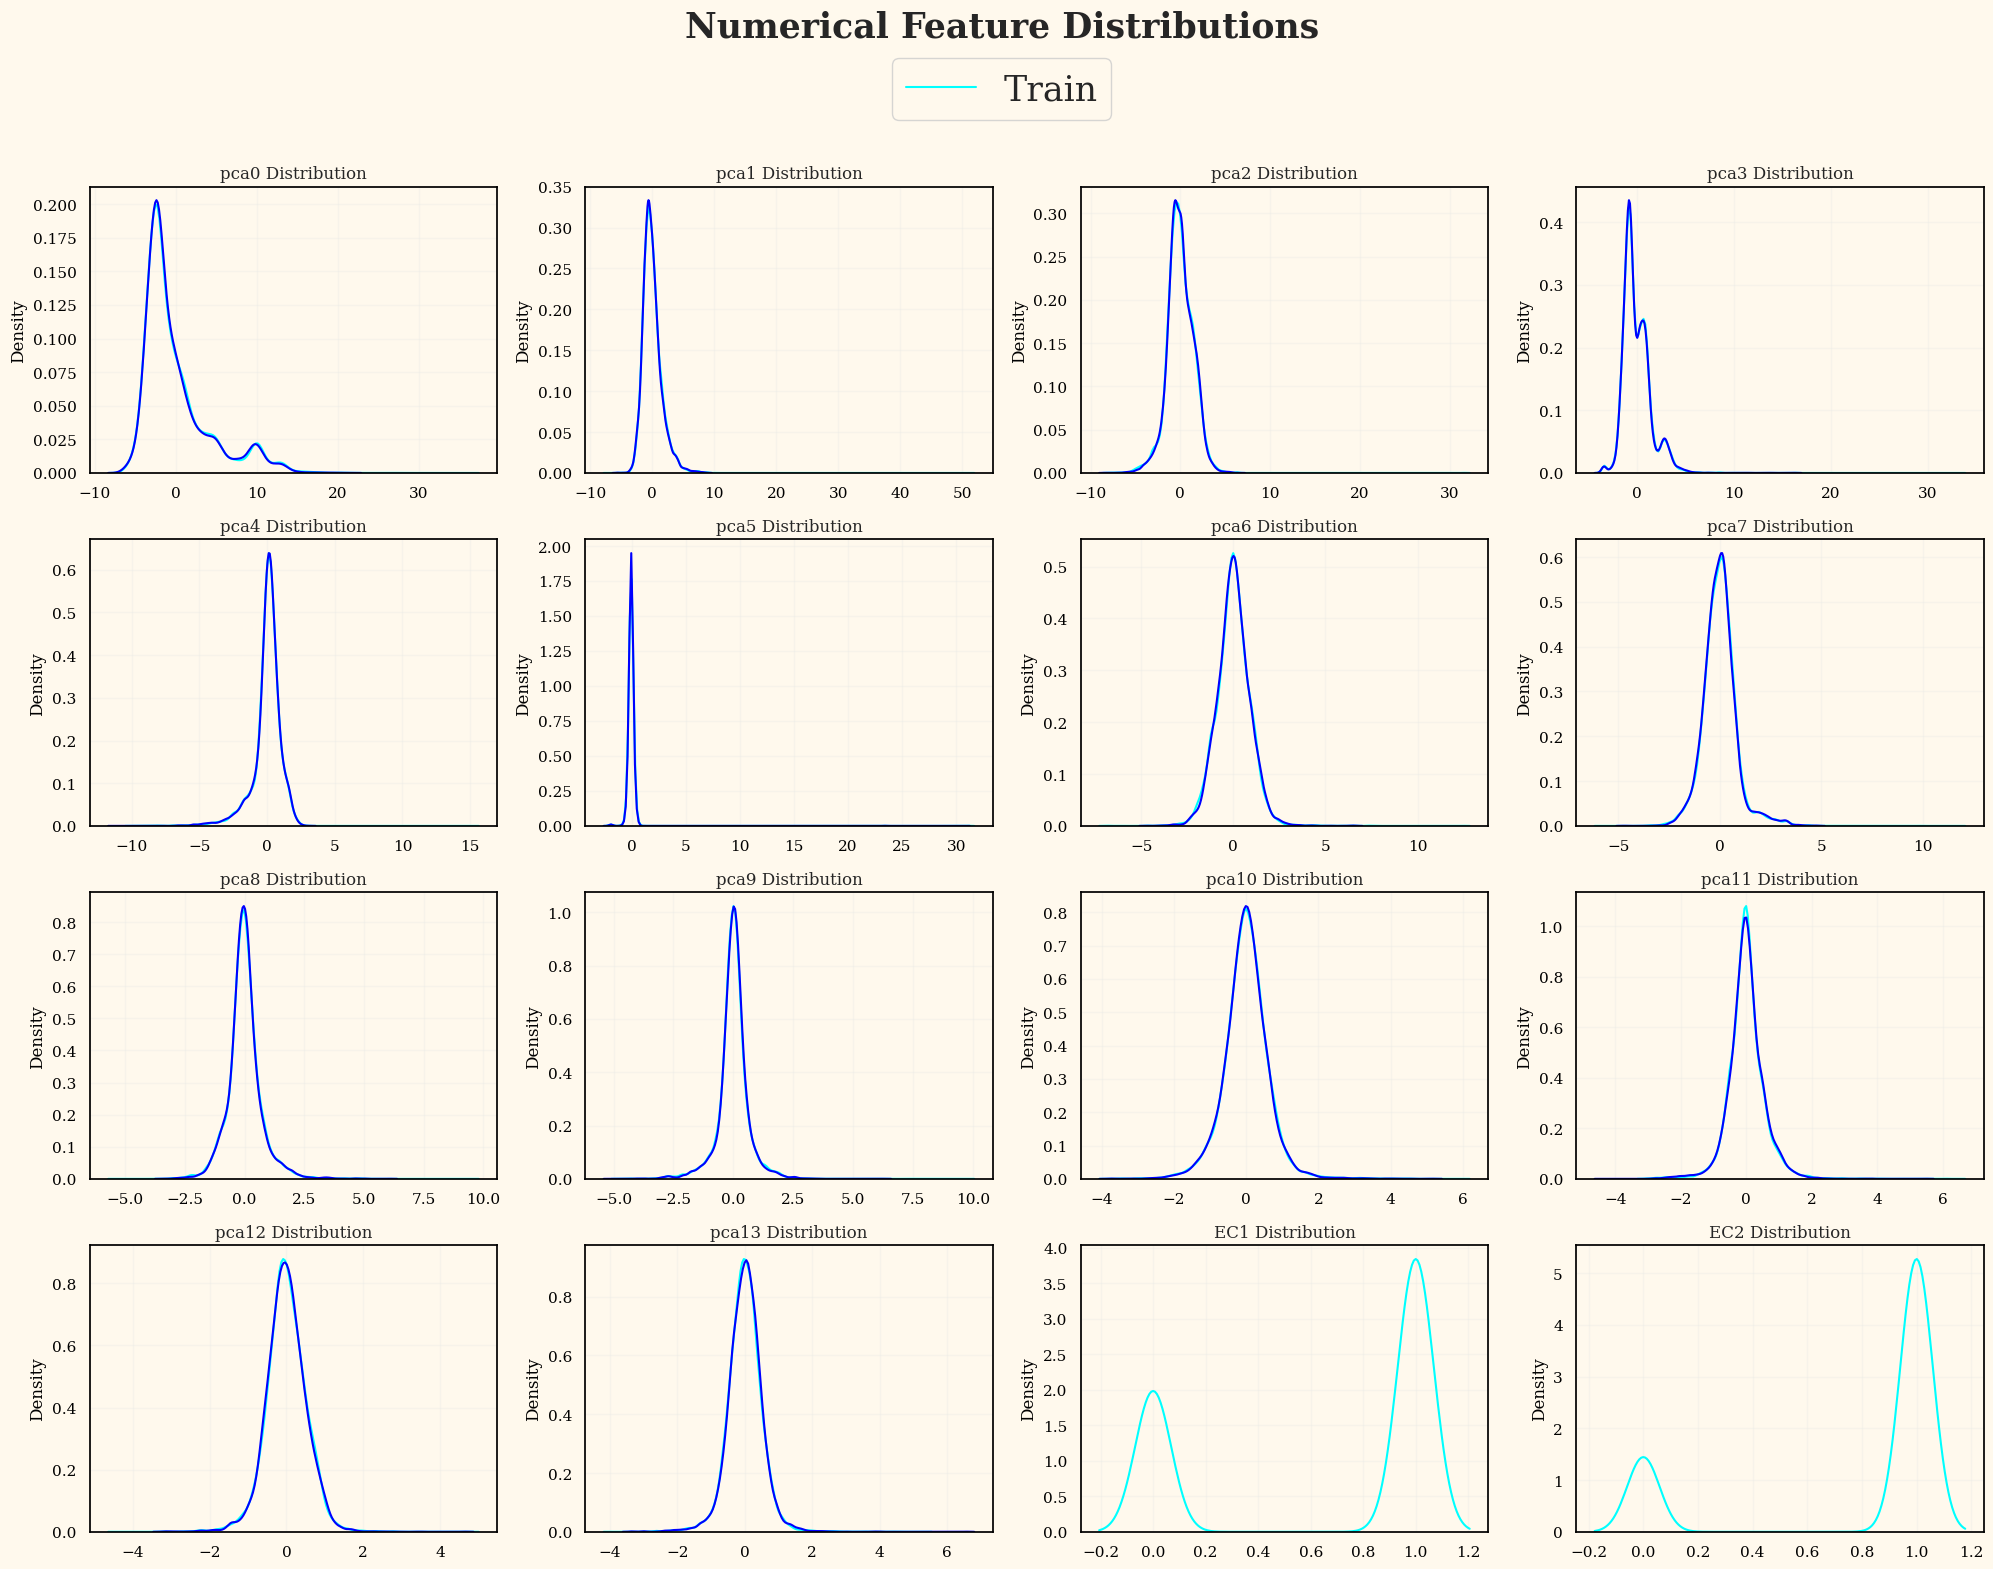

In [20]:
eda.distribution()

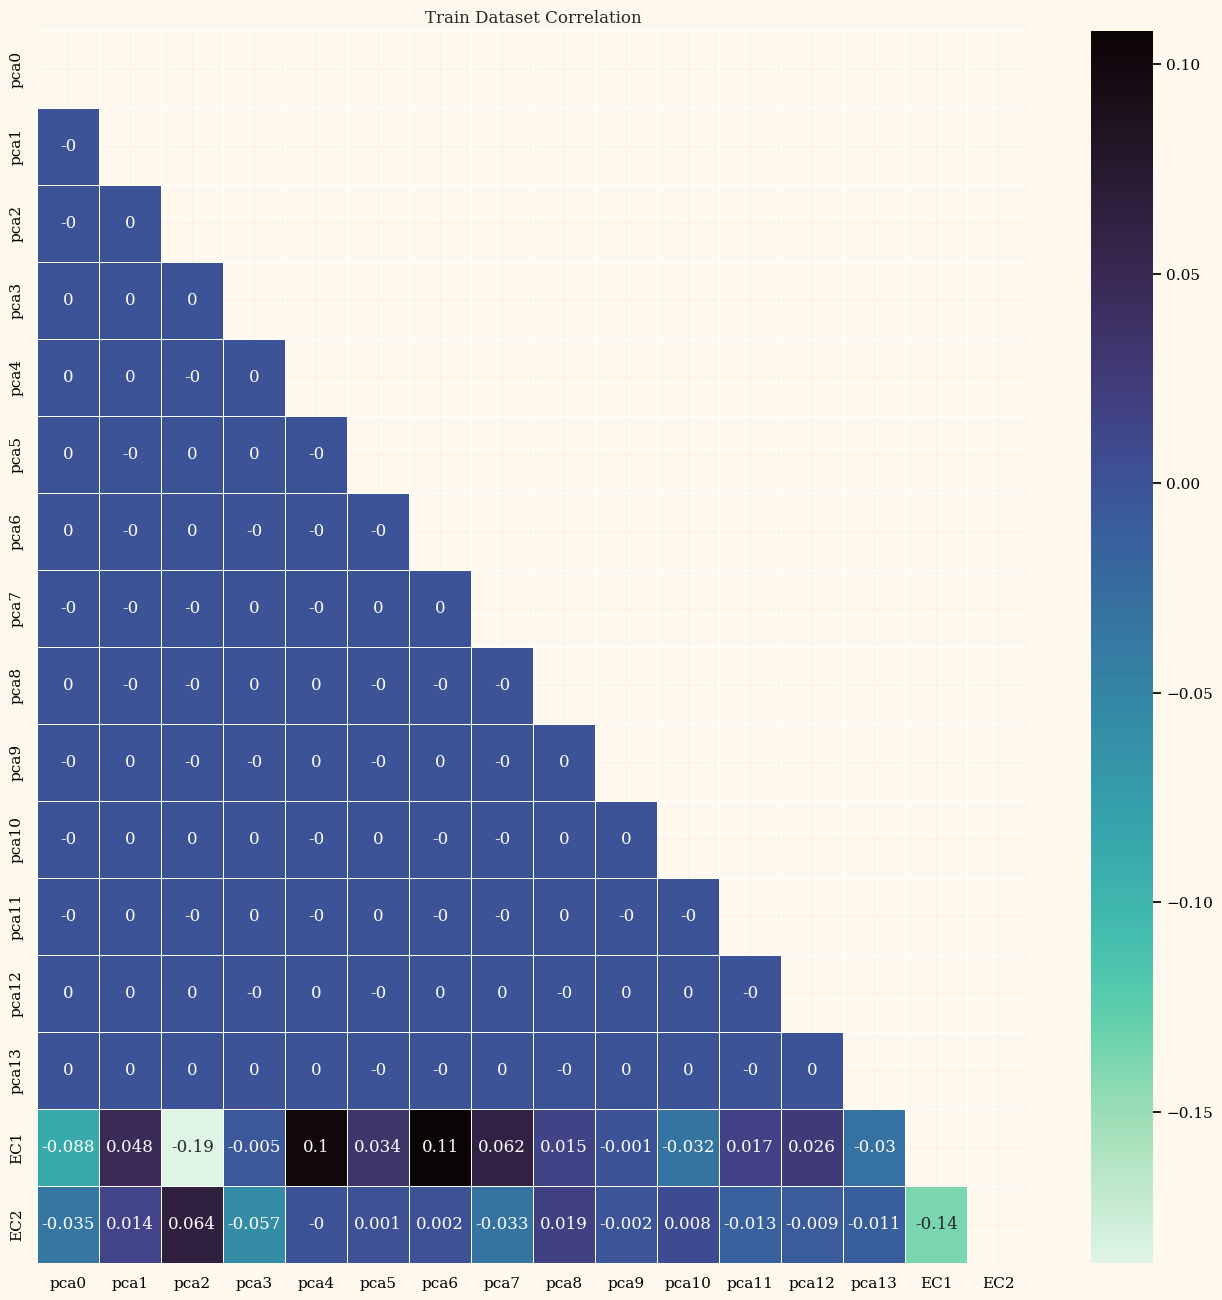

In [21]:
eda.correlation()

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#2e3ca5; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #2e3ca5">Baseline Modelling</p>

In [22]:
cat1_params = {
                'iterations': 564, 
                'depth': 7, 
                'learning_rate': 0.07934909738804613, 
                'random_strength': 0.911881028908019, 
                'l2_leaf_reg': 3.625569427932605,
                'grow_policy': 'SymmetricTree',
                'bootstrap_type': 'Bayesian',
                'objective':'Logloss',
                "loss_function": "Logloss",
                'eval_metric': "AUC",
                'random_state': RANDOM_STATE,
                'silent': True
            }


cat2_params =  {
                'iterations': 922, 
                'depth': 5, 
                'learning_rate': 0.04096826560197795, 
                'random_strength': 0.6995629319789216, 
                'l2_leaf_reg': 2.4277036409588826,
                'grow_policy': 'SymmetricTree',
                'bootstrap_type': 'Bayesian',
                'objective':'Logloss',
                "loss_function": "Logloss",
                'eval_metric': "AUC",
                'random_state': RANDOM_STATE,
                'silent': True
            }

In [23]:
feature_names = train.drop(['EC1', 'EC2'], axis = 1).columns.tolist()

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#2e3ca5; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #2e3ca5">EC1</p>

In [24]:
X_train = train.drop(columns = [TARGET1, TARGET2])
X_test = test
y_train = train[TARGET1].copy()

NFOLDS = 10
cat_cols = []

#class imbalance: stratified is better
folds = StratifiedKFold(n_splits=NFOLDS, shuffle = True, random_state = RANDOM_STATE)

splits = folds.split(X_train, y_train)
ec1_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
score = 0
for fold_n, (train_index, valid_index) in enumerate(splits):

    #--------------------------------CATBOOST--------------------------------------------

    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[valid_index]

    pool_train = Pool(X_tr, y_tr, feature_names = feature_names, cat_features = cat_cols)
    pool_valid = Pool(X_val, y_val, feature_names = feature_names, cat_features = cat_cols)

    c1_reg = CatBoostClassifier(**cat1_params)
    c1_reg.fit(pool_train, eval_set=pool_valid, silent=True)
    y_pred_valid_cat = c1_reg.predict_proba(pool_valid)[:, 1]

    #--------------------------------COMBINED--------------------------------------------
    y_pred_valid = y_pred_valid_cat

    y_oof[valid_index] = y_pred_valid

    print(f"Fold {fold_n + 1} | ROC: {roc_auc_score(y_val, y_pred_valid)}")
    score += roc_auc_score(y_val, y_pred_valid) / NFOLDS

    # Predict the test set
    pool_test = Pool(X_test, feature_names=feature_names, cat_features = cat_cols)
    cur_preds = c1_reg.predict_proba(pool_test)[:, 1] #(FACTOR * catboost_reg.predict_proba(X_test)[:, 1]) + ((1 - FACTOR) * lightgbm_reg.predict_proba(X_test)[:, 1])
    ec1_preds += cur_preds / NFOLDS
    del X_tr, X_val, y_tr, y_val
    gc.collect()

print(f"\nMean ROC = {Fore.LIGHTMAGENTA_EX}{score}{Fore.BLACK}")
print(f"Out of folds ROC Generated + Original = {Fore.GREEN}{roc_auc_score(y_train, y_oof)}{Fore.BLACK}")
print(f"Out of folds ROC Generated = {Fore.BLUE}{roc_auc_score(y_train[:TRAIN_SIZE], y_oof[:TRAIN_SIZE])}{Fore.BLACK}")

score1 = roc_auc_score(y_train[:TRAIN_SIZE], y_oof[:TRAIN_SIZE])

Fold 1 | ROC: 0.7046103185265747
Fold 2 | ROC: 0.6903002580342482
Fold 3 | ROC: 0.7110416266820208
Fold 4 | ROC: 0.6911452668841832
Fold 5 | ROC: 0.6901376604139069
Fold 6 | ROC: 0.6946465196769644
Fold 7 | ROC: 0.6992317366238747
Fold 8 | ROC: 0.7057866116899126
Fold 9 | ROC: 0.6893087052654235
Fold 10 | ROC: 0.6833452809346523

Mean ROC = 0.6959553984731761
Out of folds ROC Generated + Original = 0.6955105489023063
Out of folds ROC Generated = 0.6975579276725884


# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#2e3ca5; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #2e3ca5">EC2</p>

In [25]:
X_train = train.drop(columns = [TARGET1, TARGET2])
X_test = test
y_train = train[TARGET2].copy()

NFOLDS = 10
cat_cols = []

#class imbalance: stratified is better
folds = StratifiedKFold(n_splits=NFOLDS, shuffle = True, random_state = RANDOM_STATE)

splits = folds.split(X_train, y_train)
ec2_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])
score = 0
for fold_n, (train_index, valid_index) in enumerate(splits):

    #--------------------------------CATBOOST--------------------------------------------

    X_tr, X_val = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[valid_index]

    pool_train = Pool(X_tr, y_tr, feature_names = feature_names, cat_features = cat_cols)
    pool_valid = Pool(X_val, y_val, feature_names = feature_names, cat_features = cat_cols)

    c2_reg = CatBoostClassifier(**cat2_params)
    c2_reg.fit(pool_train, eval_set=pool_valid, silent=True)
    y_pred_valid_cat = c2_reg.predict_proba(pool_valid)[:, 1]

    #--------------------------------COMBINED--------------------------------------------
    y_pred_valid = y_pred_valid_cat

    y_oof[valid_index] = y_pred_valid

    print(f"Fold {fold_n + 1} | ROC: {roc_auc_score(y_val, y_pred_valid)}")
    score += roc_auc_score(y_val, y_pred_valid) / NFOLDS

    # Predict the test set
    pool_test = Pool(X_test, feature_names=feature_names, cat_features = cat_cols)
    cur_preds = c2_reg.predict_proba(pool_test)[:, 1] #(FACTOR * catboost_reg.predict_proba(X_test)[:, 1]) + ((1 - FACTOR) * lightgbm_reg.predict_proba(X_test)[:, 1])
    ec2_preds += cur_preds / NFOLDS
    del X_tr, X_val, y_tr, y_val
    gc.collect()

print(f"\nMean ROC = {Fore.LIGHTMAGENTA_EX}{score}{Fore.BLACK}")
print(f"Out of folds ROC Generated + Original = {Fore.GREEN}{roc_auc_score(y_train, y_oof)}{Fore.BLACK}")
print(f"Out of folds ROC Generated = {Fore.BLUE}{roc_auc_score(y_train[:TRAIN_SIZE], y_oof[:TRAIN_SIZE])}{Fore.BLACK}")

score2 = roc_auc_score(y_train[:TRAIN_SIZE], y_oof[:TRAIN_SIZE])

Fold 1 | ROC: 0.5931404098244286
Fold 2 | ROC: 0.5734276655151199
Fold 3 | ROC: 0.6236027880487909
Fold 4 | ROC: 0.575628892950071
Fold 5 | ROC: 0.590036231884058
Fold 6 | ROC: 0.5714596949891068
Fold 7 | ROC: 0.6058326229042341
Fold 8 | ROC: 0.5653523728331913
Fold 9 | ROC: 0.5822238798901203
Fold 10 | ROC: 0.6185611442644692

Mean ROC = 0.5899265703103589
Out of folds ROC Generated + Original = 0.5861555530377871
Out of folds ROC Generated = 0.5873666682484702


In [26]:
c1_reg.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'AUC',
 'iterations': 564,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3.6255693435668945,
 'random_strength': 0.9118810296058656,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'use_best_model': True,
 'class_names': [0, 1],
 'random_seed': 42,
 'depth': 7,
 'posterior_sampling': False,
 'border_count': 254,
 'bagging_temperature': 1,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'Logloss',
 'lea

In [27]:
c2_reg.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'AUC',
 'iterations': 922,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 2.427703619003296,
 'random_strength': 0.6995629072189331,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'use_best_model': True,
 'class_names': [0, 1],
 'random_seed': 42,
 'depth': 5,
 'posterior_sampling': False,
 'border_count': 254,
 'bagging_temperature': 1,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'Logloss',
 'lear

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#2e3ca5; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #2e3ca5">CV score</p>

In [28]:
print(f"Out of folds ROC Generated = {Fore.BLUE}{(score1 + score2) / 2}{Fore.BLACK}")

Out of folds ROC Generated = 0.6424622979605292


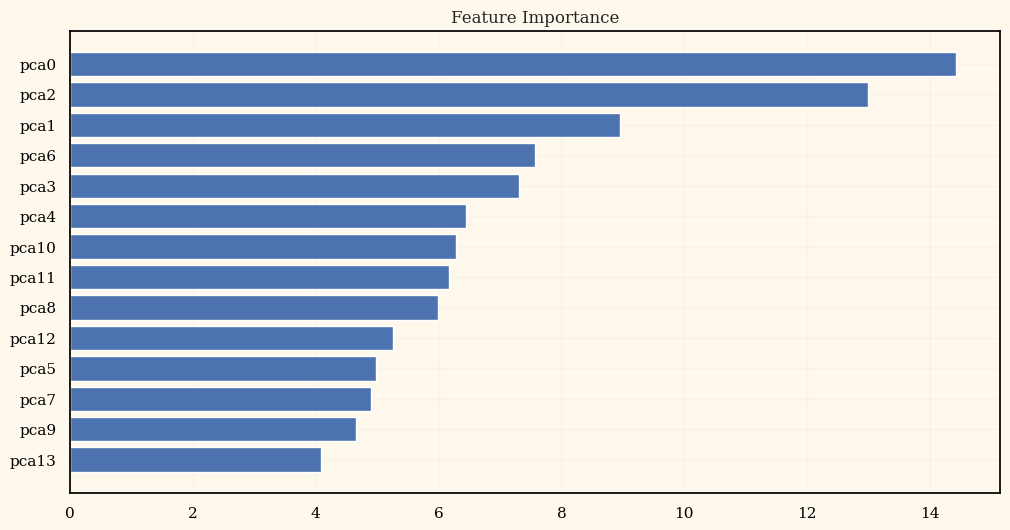

In [29]:
feature_importance = c1_reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

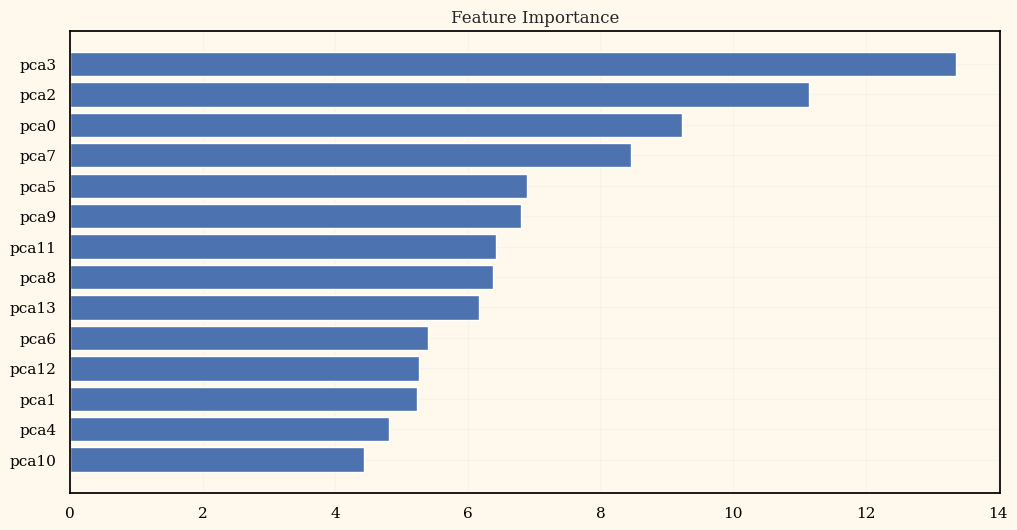

In [30]:
feature_importance = c2_reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

# <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 2px; color:#2e3ca5; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #2e3ca5">Predict!</p>

In [31]:
ec1_preds

array([0.39031361, 0.79654959, 0.73394222, ..., 0.46503962, 0.46576693,
       0.36544284])

In [32]:
ec2_preds

array([0.79305103, 0.80006546, 0.75806542, ..., 0.81806309, 0.86728591,
       0.8623474 ])

In [33]:
sub = pd.read_csv(DATA_DIR + 'sample_submission.csv')
backup = pd.read_csv("/kaggle/input/ec-class-prediction-dataset/65540_submission.csv")

sub['EC1'] = (ec1_preds + backup["EC1"]) / 2
sub['EC2'] = (ec2_preds + backup["EC2"]) / 2
sub.to_csv('submission.csv',index=False)
sub

,id,EC1,EC2
0,14838,0.439727,0.760366
1,14839,0.771712,0.768340
2,14840,0.738428,0.742428
3,14841,0.722284,0.776388
4,14842,0.746171,0.741267
...,...,...,...
9888,24726,0.617266,0.737256
9889,24727,0.745097,0.797924
9890,24728,0.415372,0.781869
9891,24729,0.494193,0.810520
